# Permutation Test

In [1]:
%run setup.py

In [2]:
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))

df_Invited.head()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper,Age,Conference (long),Main Topic,Productivity
0,Glovanni De WIichcli,2003,ASPDAC,Glovanni,De,WIichcli,M,0,0,0,0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.000000
1,Tadahiro Ohm,2003,ASPDAC,Tadahiro,NaN,Ohm,M,27,92,1993,10,Asia and South Pacific Design Automation Confe...,Computer Architecture,2.700000
2,Ycrvant Zorian,2003,ASPDAC,Ycrvant,NaN,Zorian,M,0,0,0,0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.000000
3,Gary L. Baldwi,2004,ASPDAC,Gary,L.,Baldwi,M,4,4,1962,42,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.095238
4,Rudy Lauwereins,2004,ASPDAC,Rudy,NaN,Lauwereins,M,112,196,1987,17,Asia and South Pacific Design Automation Confe...,Computer Architecture,6.588235


## Define functions

In [4]:
def Permutation_test(df,n,column): 
    # Drop all rows with 0 values
    df = df[df[column] != 0]

    # Save the true values
    True_avg_F = df.groupby('gender')[column].mean()[0] # female
    True_avg_M = df.groupby('gender')[column].mean()[1] # male
    True_delta = True_avg_F - True_avg_M
    
    # initialize the lists to store the averages
    avg_F = []
    avg_M = []

    prop_F = len(df[df['gender'] == 'F']) / len(df)
    prop_M = len(df[df['gender'] == 'M']) / len(df)

    for i in range(n):
        # randomly assign a new gender to each row
        df['gender'] = np.random.choice(['F', 'M'], size=len(df), p=[prop_F, prop_M])
        
        # Insert a control check
        while len(df.groupby('gender').count()) < 2:
            df['gender'] = np.random.choice(['F', 'M'], size=len(df), p=[prop_F, prop_M])

        # calculate and store the average value for each gender
        avg_F.append(df.groupby('gender')[column].mean()[0]) # female
        avg_M.append(df.groupby('gender')[column].mean()[1]) # male
        
    delta = [x - y for x, y in zip(avg_F, avg_M)]
    
    return avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta

In [5]:
def Permutation_plot(avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta, column):
    # calculate the weights for the histogram
    weights_F = np.ones_like(avg_F) / len(avg_F)
    weights_M = np.ones_like(avg_M) / len(avg_M)
    weights_D = np.ones_like(delta) / len(delta)
    
    # calculate the bins for the histogram
    bins=np.histogram(np.hstack((avg_M,avg_F)), bins=40)[1]
    
    # Plot the distribution of the averages
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ###### Histogram of the simulated averages ######
    # Plot histogram
    ax1.hist(avg_F, alpha=0.7, weights=weights_F, bins=bins, label="Simulated avg. female "+column)
    ax1.hist(avg_M, alpha=0.7, weights=weights_M, bins=bins, label="Simulated avg. male "+column)
    # Plot lines 
    ax1.axvline(True_avg_F, color='red', linestyle='dashed', linewidth=2, label = "True avg. female "+column+": "+str(round(True_avg_F,2)))
    ax1.axvline(True_avg_M, color='blue', linestyle='dashed', linewidth=2, label = "True avg. male "+column+": "+str(round(True_avg_M,2)))
    # Legend, title, labels
    ax1.legend( prop={'size': 8})
    ax1.set_title("Distribution of the simulated averages")
    ax1.set_xlabel(column)
    ax1.set_ylabel("Probability Density")


    ###### Histogram of the simulated deltas ######
    # Plot histogram
    ax2.hist(delta, label="F_"+column+" - M_"+column, alpha = 0.7, weights=weights_D, bins=40)
    # Plot line
    ax2.axvline(True_delta, color='red', linestyle='dashed', linewidth=2, label = "True delta_"+column+": "+str(round(True_delta,2)))
    # Legend, title, labels
    ax2.legend( prop={'size': 8})
    ax2.set_title("Distribution of the simulated delta")
    ax2.set_xlabel("delta_"+ column)
    ax2.set_ylabel("Probability Density")

    fig.suptitle(column, fontsize=14)

    plt.show()

In [6]:
def P_Value(df,year,column,n):
    df = df[df['Year'] == year]
    avg_F, avg_M,_, True_avg_F, True_avg_M,_ = Permutation_test(df,n,column)
    return len([x for x in avg_F if x < True_avg_F]) / len(avg_F), len([x for x in avg_M if x < True_avg_M]) / len(avg_M)

In [7]:
def P_Value_plot(list_F,list_M,column):
    plt.plot(range(2003,2023),list_F,label='F')
    plt.plot(range(2003,2023),list_M,label='M')
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('P-value')
    plt.title('P-value for '+column)
    plt.xticks(range(2003,2023,2))
    plt.axhline(y=0.05, color='black', linestyle='--',linewidth=1)
    plt.show()

## Permutation test for Age, Paper Count, Productivity

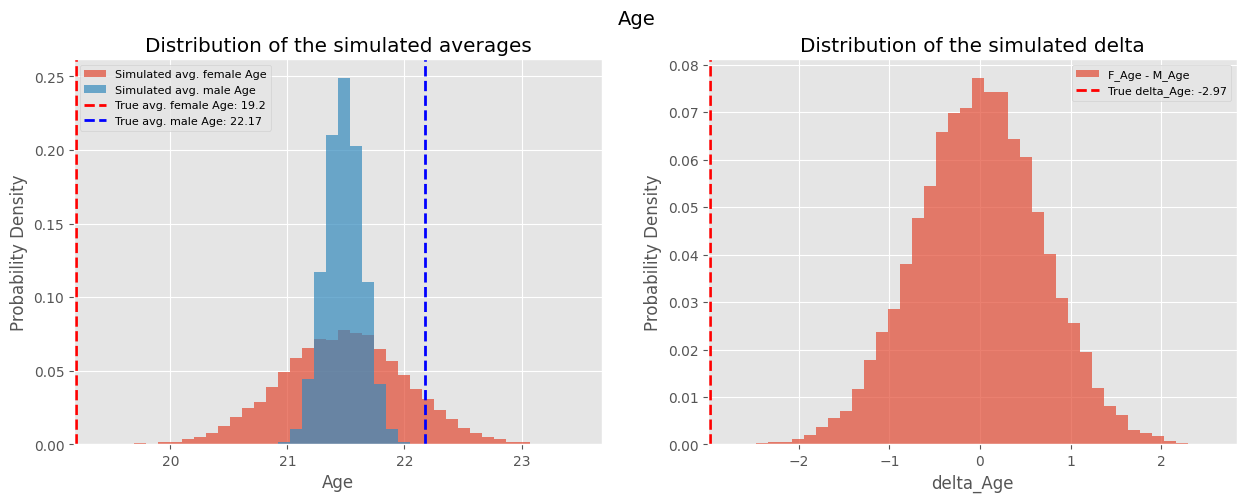

In [8]:
avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta = Permutation_test(df_Invited,10000,'Age')
Permutation_plot(avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta, 'Age')

same

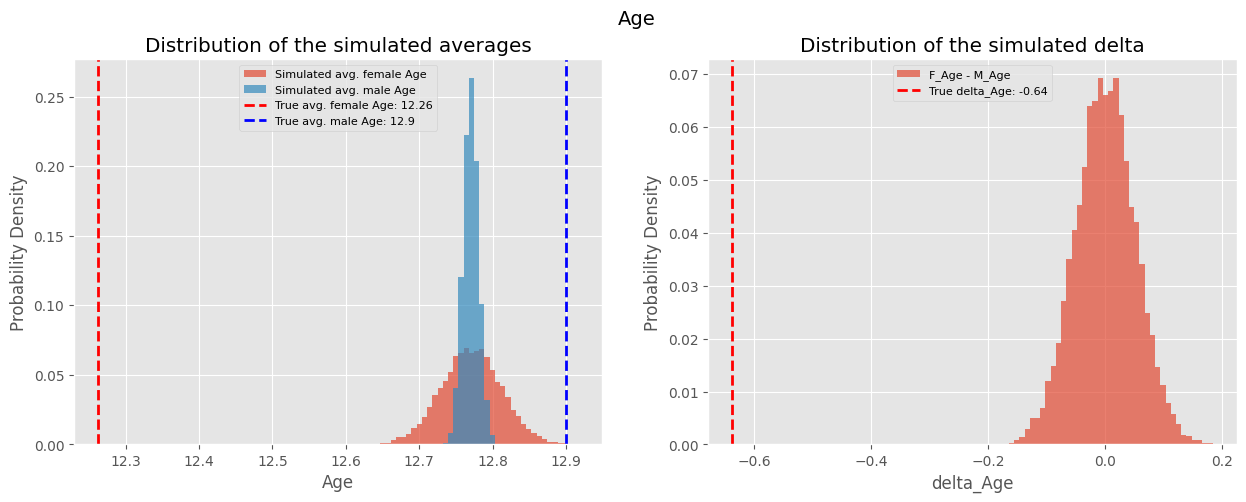

In [9]:
avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta = Permutation_test(df_Proceedings,10000,'Age')
Permutation_plot(avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta, 'Age')

same

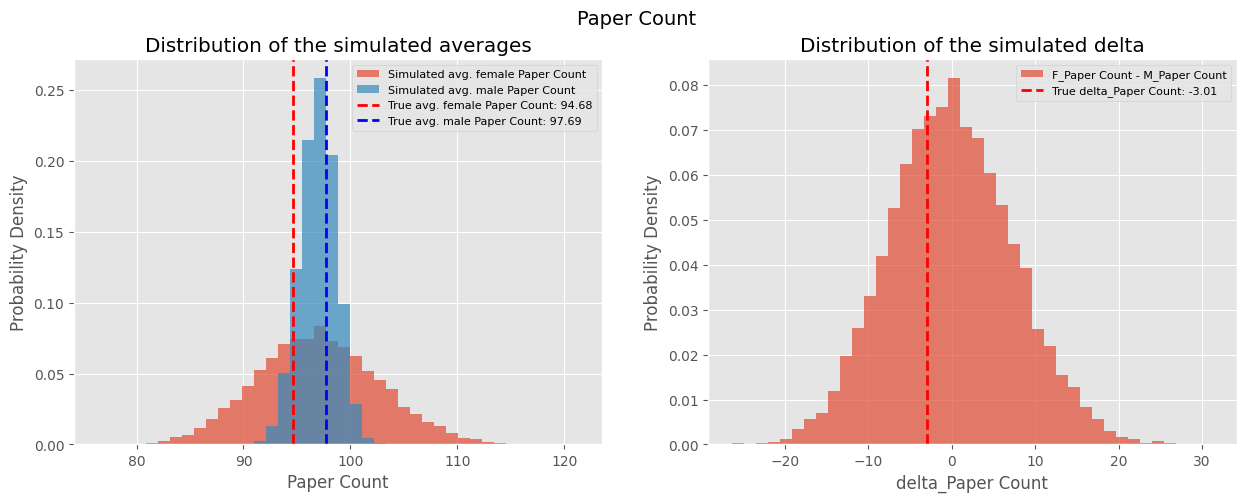

In [10]:
avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta = Permutation_test(df_Invited,10000,'Paper Count')
Permutation_plot(avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta, 'Paper Count')

same

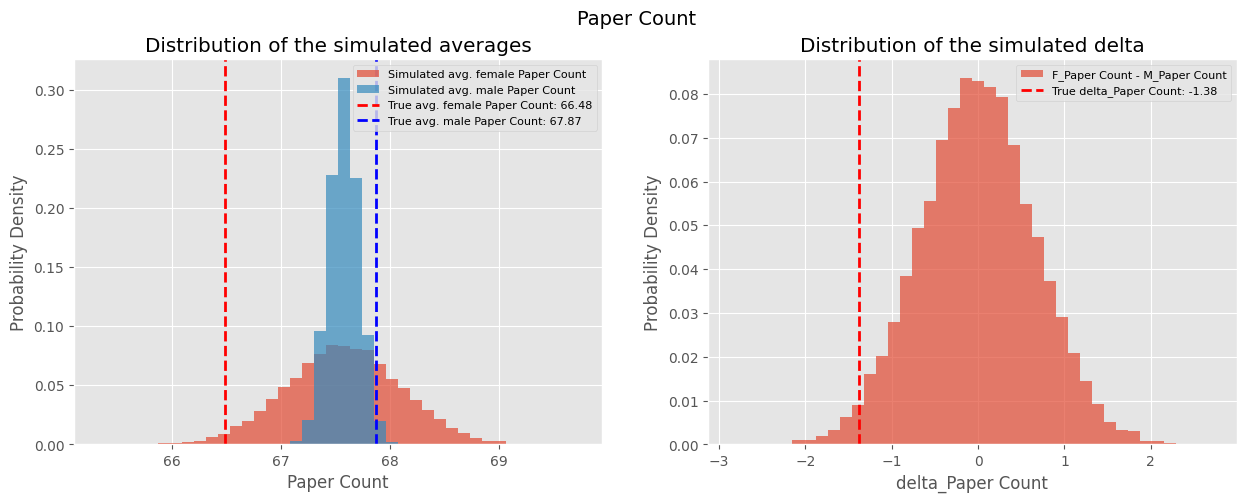

In [11]:
avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta = Permutation_test(df_Proceedings,10000,'Paper Count')
Permutation_plot(avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta, 'Paper Count')

The mean is much small now and the two lines are a bit more closer.

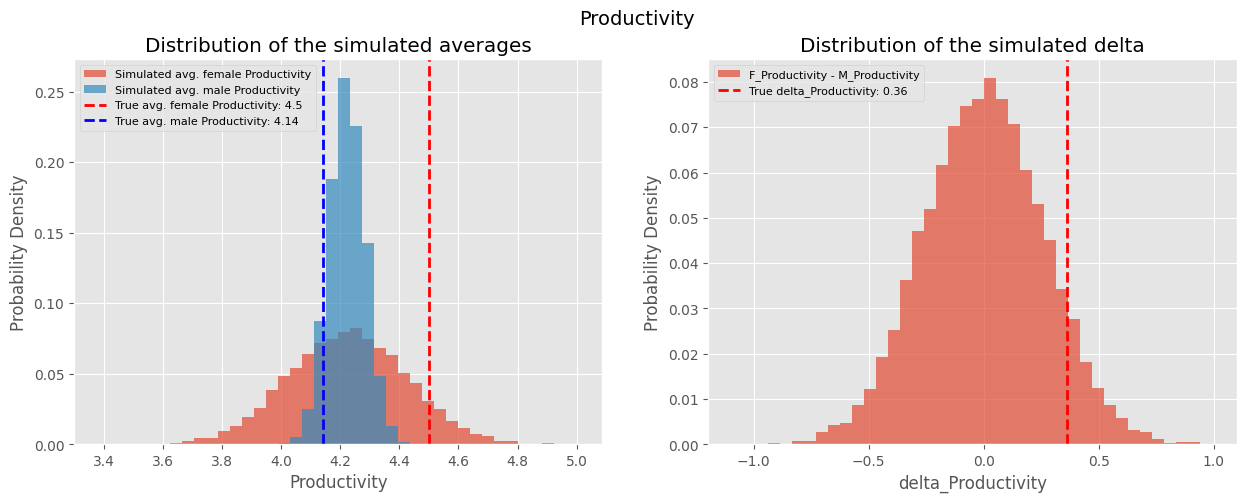

In [12]:
avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta = Permutation_test(df_Invited,10000,'Productivity')
Permutation_plot(avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta, 'Productivity')

same

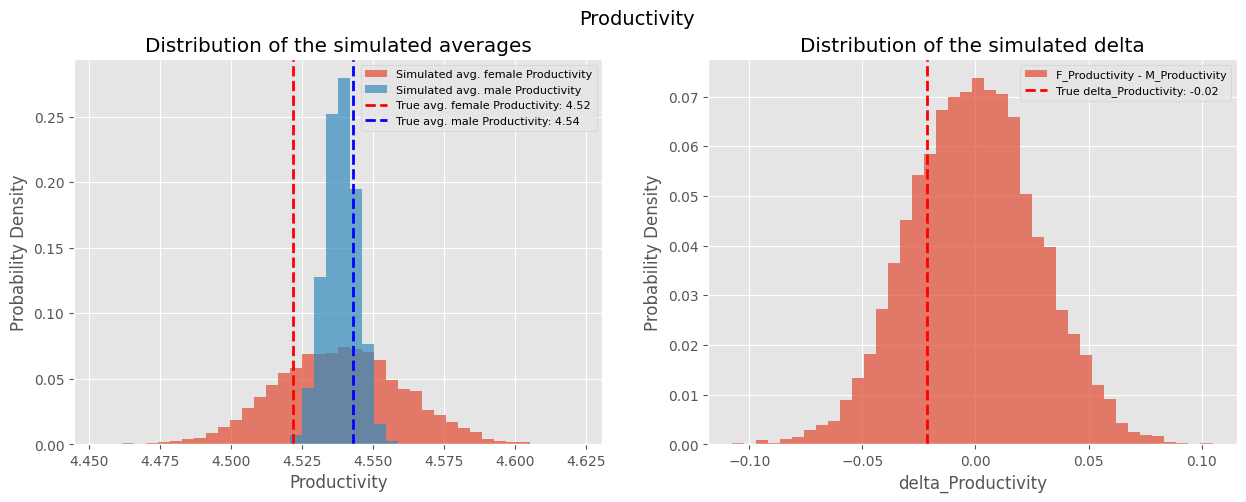

In [13]:
avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta = Permutation_test(df_Proceedings,5000,'Productivity')
Permutation_plot(avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta, 'Productivity')

same

## P-Value plot

In [14]:
P_Value_F_list = []
P_Value_M_list = []
column = 'Age'

for year in range(2003,2023):
    P_Value_F, P_Value_M = P_Value(df_Invited,year,column,10000)
    P_Value_F_list.append(P_Value_F)
    P_Value_M_list.append(P_Value_M)
    
# Plot the P-value
P_Value_plot(P_Value_F_list,P_Value_M_list,column)

KeyboardInterrupt: 

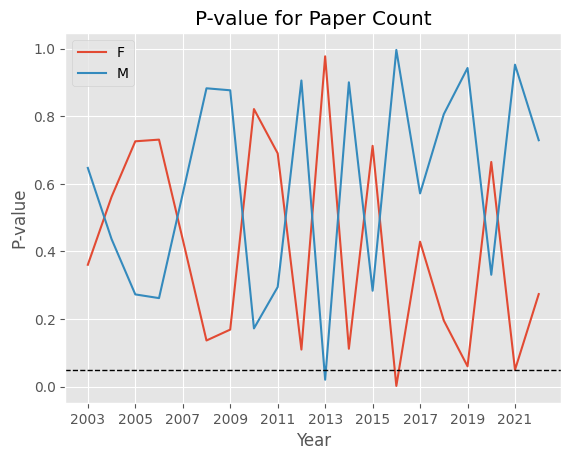

In [ ]:
P_Value_F_list = []
P_Value_M_list = []
column = 'Paper Count'

for year in range(2003,2023):
    P_Value_F, P_Value_M = P_Value(df_Invited,year,column,10000)
    P_Value_F_list.append(P_Value_F)
    P_Value_M_list.append(P_Value_M)
    
# Plot the P-value
P_Value_plot(P_Value_F_list,P_Value_M_list,column)

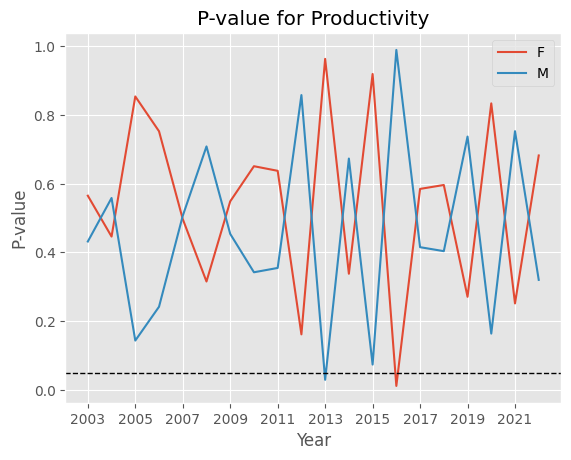

In [ ]:
P_Value_F_list = []
P_Value_M_list = []
column = 'Productivity'

for year in range(2003,2023):
    P_Value_F, P_Value_M = P_Value(df_Invited,year,column,10000)
    P_Value_F_list.append(P_Value_F)
    P_Value_M_list.append(P_Value_M)
    
# Plot the P-value
P_Value_plot(P_Value_F_list,P_Value_M_list,column)